In [70]:
# Import functions
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

In [71]:
# Genus/species labels
taxon_labels = '/scicomp/home-pure/rqu4/PROJECTS/GaTech/FCGR_classifier/data_final/enterobacteriaceae/metadata/metadata_tax_assignments_filtered.csv'

df_tax = pd.read_csv(taxon_labels, sep=',')

df_tax['genus'] = df_tax['organism_organism_name'].str.split('_').str[0]
df_tax['species'] = df_tax['organism_organism_name'].str.split('_').str[1]
df_tax['species'] = df_tax['species'].replace("sp.", np.nan)
print(df_tax.shape)
df_tax.head()

(9525, 4)


,accession,organism_organism_name,genus,species
0,GCF_001461805.1,Enterobacter_lignolyticus,Enterobacter,lignolyticus
1,GCF_000164865.1,Enterobacter_lignolyticus_SCF1,Enterobacter,lignolyticus
2,GCF_016027855.1,Atlantibacter_hermannii,Atlantibacter,hermannii
3,GCF_008064855.1,Atlantibacter_hermannii,Atlantibacter,hermannii
4,GCF_011068345.1,Atlantibacter_hermannii,Atlantibacter,hermannii


['GCF_000005845.2_ASM584v2_genomic_k5_k5.npy', 'GCF_000006925.2_ASM692v2_genomic_k5_k5.npy', 'GCF_000008105.1_ASM810v1_genomic_k5_k5.npy', 'GCF_000007445.1_ASM744v1_genomic_k5_k5.npy', 'GCF_000007405.1_ASM740v1_genomic_k5_k5.npy']
(32, 32)
[[ 2975.  3687.  6749. ... 10000. 10000. 10000.]
 [ 5661.     0.  3735. ... 10000. 10000. 10000.]
 [10000.  6415.  3771. ... 10000.  4935. 10000.]
 ...
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.  3669.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]]


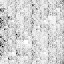

In [68]:
# FCGR_arrays for 5-mer counts
FCGR_array_dir = '/scicomp/home-pure/rqu4/PROJECTS/GaTech/FCGR_classifier/data_final/enterobacteriaceae/data/FCGR_arrays'

contents = os.listdir(FCGR_array_dir)

print(contents[:5])

# Example FCGR array
e_FCGR = FCGR_array_dir + '/' + 'GCF_000005845.2_ASM584v2_genomic_k5_k5.npy'

array = np.load(e_FCGR)

print(array.shape)
print(array)

##### Example of FCGR visualization. Lines commented out because code isnt compatible with this enviornment

# from complexcgr import FCGR
# from complexcgr import FCGRKmc

# kmer = 6
# fcgr = FCGRKmc(kmer)

# arr = fcgr("/scicomp/home-pure/rqu4/PROJECTS/GaTech/FCGR_classifier/kmc-test.txt") # k-mer counts ordered in a matrix of 2^k x 2^k

# # to visualize the distribution of k-mers. 
# # Frequencies are scaled between [min, max] values. 
# # White color corresponds to the minimum value of frequency
# # Black color corresponds to the maximum value of frequency
# fcgr.plot(arr)

# Define the path to your PNG file
png_file_path = '/scicomp/home-pure/rqu4/PROJECTS/GaTech/FCGR_classifier/data_final/fcgr_example.png'

# Display the image
display(Image(filename=png_file_path, width=200, height=100))

In [72]:
# --- Step 0: Filter classes with at least 12 samples ---

# Assume:
# - X_to_split: your full feature matrix, shape (N_samples, N_features)
# - y_encoded_to_split: your original encoded labels (int or str)
# Note: y_encoded_to_split can be original labels, but encoding below will handle mapping

# Convert to numpy arrays if not already
X_to_split = np.array(X_to_split)
y_encoded_to_split = np.array(y_encoded_to_split)

# Count samples per class
(unique, counts) = np.unique(y_encoded_to_split, return_counts=True)
class_counts = dict(zip(unique, counts))

# Select classes with >=12 samples
classes_to_keep = [cls for cls, count in class_counts.items() if count >= 12]

# Filter data
indices_to_keep = [i for i, label in enumerate(y_encoded_to_split) if label in classes_to_keep]
X_filtered = X_to_split[indices_to_keep]
y_filtered = y_encoded_to_split[indices_to_keep]

print(f"[INFO] Classes before filtering: {len(class_counts)}")
print(f"[INFO] Classes after filtering (>=12 samples): {len(classes_to_keep)}")
print(f"[INFO] Samples after filtering: {len(y_filtered)}")

# --- Step 1: Encode filtered labels to contiguous integers ---
final_label_encoder = LabelEncoder()
y_filtered_contiguous = final_label_encoder.fit_transform(y_filtered)

num_classes_final = len(final_label_encoder.classes_)

# --- Step 2: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y_filtered_contiguous,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered_contiguous
)

print(f"\n[INFO] XGBoost Training Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")
print(f"[INFO] Number of classes (filtered): {num_classes_final}")

# --- Step 3: Train XGBoost Classifier ---
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # use 'multi:softprob' if you want probabilities
    num_class=num_classes_final,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# --- Step 4: Predict and evaluate ---
y_pred = xgb_model.predict(X_test)

used_labels = [int(i) for i in unique_labels(y_test, y_pred)]
target_names = [str(final_label_encoder.classes_[i]) for i in used_labels]

print("\n[CLASSIFICATION REPORT]")
print(classification_report(
    y_test,
    y_pred,
    labels=used_labels,
    target_names=target_names,
    zero_division=0
))

[INFO] Classes before filtering: 31
[INFO] Classes after filtering (>=12 samples): 31
[INFO] Samples after filtering: 9155

[INFO] XGBoost Training Samples: 7324, Test Samples: 1831
[INFO] Number of classes (filtered): 31


/scicomp/home-pure/rqu4/cache/python/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:13:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00         2
           4       0.92      1.00      0.96        11
           5       1.00      1.00      1.00         2
           6       0.88      0.88      0.88         8
           7       1.00      1.00      1.00         4
           8       1.00      0.70      0.82        10
           9       0.99      1.00      0.99       715
          10       1.00      0.67      0.80         6
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00       272
          13       0.93      0.70      0.80        20
          14       0.89      0.97      0.93        35
          15       0.67      1.00      0.80         4
          16       1.00      1.00      1.00        77
  